In [4]:
!pip install tensorflow


  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using ca

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
SEED = 42
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Charger les données
df = pd.read_csv("train.csv")
df = df.groupby('diagnosis', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=SEED))
df['file_path'] = df['id_code'].apply(lambda x: os.path.join("train_images", f"{x}.png"))

In [10]:
# Encode les labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['diagnosis'])
num_classes = df['label'].nunique()

In [11]:
# Charger les images
def load_images(df):
    X = []
    for path in df['file_path']:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
    return np.array(X)

In [13]:
print("Loading images...")
X = load_images(df)
y = to_categorical(df['label'], num_classes=num_classes)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15, random_state=SEED)

Loading images...


In [14]:
# Fonction pour créer un modèle ResNet50
def create_resnet50_model(name="resnet50"):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output, name=name)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer les 3 modèles
models = [create_resnet50_model(f"resnet50_{i}") for i in range(3)]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 49s 1us/step


In [16]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(patience=2, factor=0.5),
    EarlyStopping(patience=4, restore_best_weights=True)
]

In [17]:
# Entraîner chaque modèle
histories = []
for i, model in enumerate(models):
    print(f"\nTraining model {i+1}")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    histories.append(history)


Training model 1
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4243 - loss: 2.1435 - val_accuracy: 0.7455 - val_loss: 1.1393 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7191 - loss: 1.0405 - val_accuracy: 0.7273 - val_loss: 0.8815 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7493 - loss: 0.8133 - val_accuracy: 0.6364 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 993ms/step - accuracy: 0.7237 - loss: 0.7289 - val_accuracy: 0.7273 - val_loss: 0.7728 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7749 - loss: 0.5961 - val_accuracy: 0.7636 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7962 - loss: 0.6208 - val_accuracy: 0.7818 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 981ms/step - accuracy: 0.7320 - loss:

In [18]:
# Évaluer les modèles
for i, model in enumerate(models):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Model {i+1} accuracy: {acc:.4f}")


Model 1 accuracy: 0.7818
Model 2 accuracy: 0.7455
Model 3 accuracy: 0.7091


In [19]:
# Option : moyenne des prédictions
print("\nAverage Ensemble Accuracy:")
preds = [model.predict(X_val) for model in models]
avg_preds = np.mean(preds, axis=0)
final_acc = np.mean(np.argmax(avg_preds, axis=1) == np.argmax(y_val, axis=1))
print(f"Ensembled Accuracy: {final_acc:.4f}")


Average Ensemble Accuracy:
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000205032EAC00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Ensembled Accuracy: 0.7636


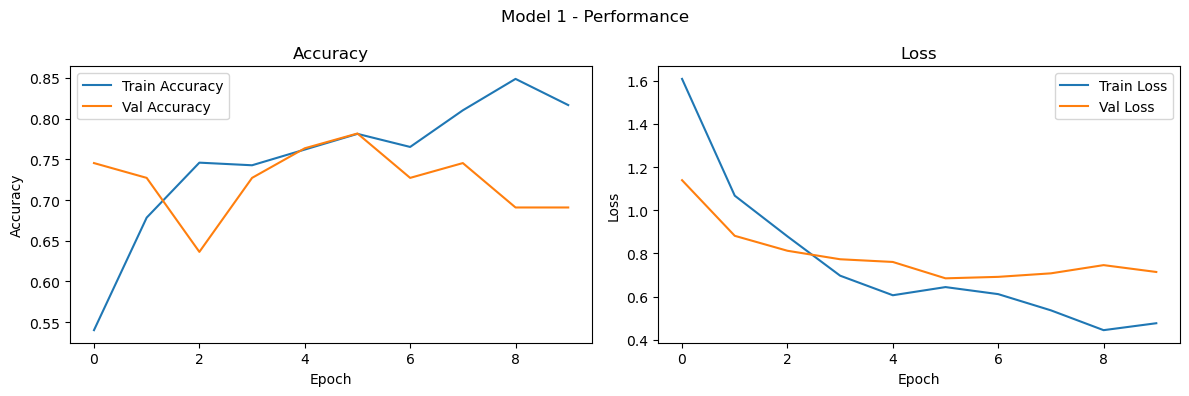

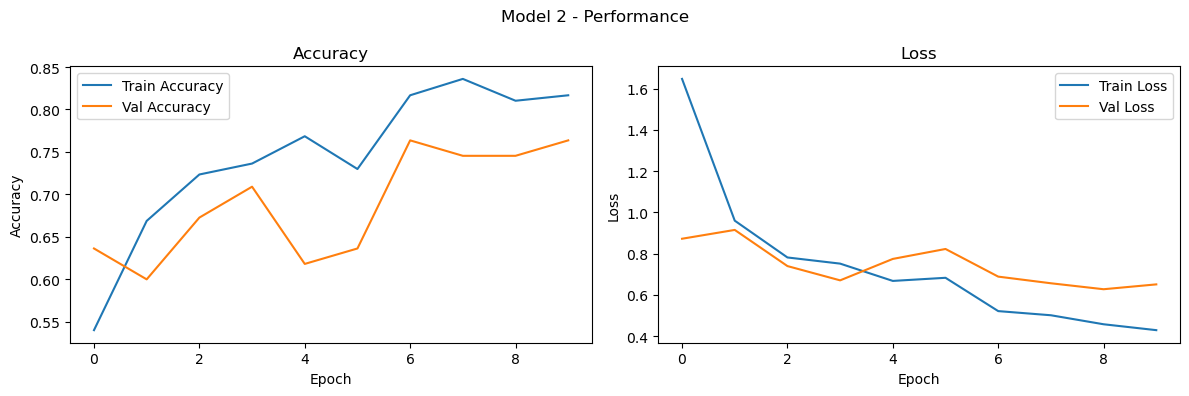

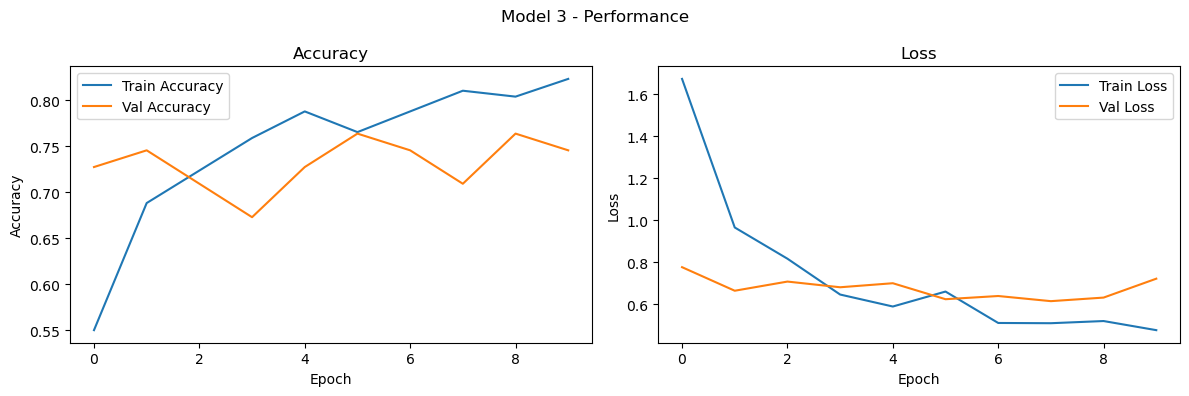

In [20]:
# Visualisation des courbes d'entraînement et de validation
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Model {i+1} - Performance')

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


<Figure size 800x600 with 0 Axes>

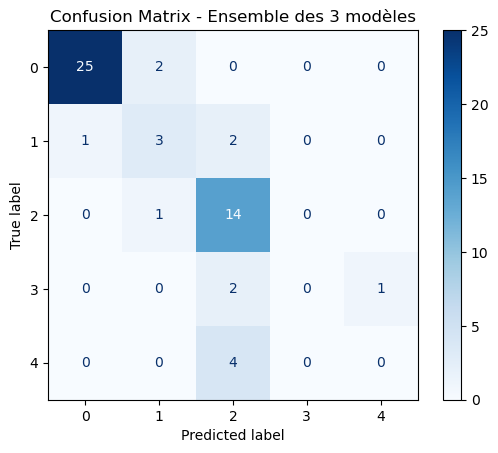

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Labels vrais et prédits (depuis les prédictions moyennes)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(avg_preds, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Affichage
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Ensemble des 3 modèles")
plt.show()


In [24]:
from sklearn.metrics import classification_report

for i, model in enumerate(models):
    preds = model.predict(X_val)
    y_pred_model = np.argmax(preds, axis=1)
    print(f"\nClassification Report - Model {i+1}:")
    print(classification_report(y_true, y_pred_model, target_names=le.classes_.astype(str)))


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

Classification Report - Model 1:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.75      0.50      0.60         6
           2       0.60      1.00      0.75        15
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4

    accuracy                           0.78        55
   macro avg       0.46      0.49      0.46        55
weighted avg       0.72      0.78      0.73        55

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

Classification Report - Model 2:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.38      0.50      0.43         6
           2       0.67      0.80      0.73        15
           3       0.00      0.00      0.00         3
           4       0.33      0.25      0.29         4

    accuracy                           0.75  

In [23]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=le.classes_.astype(str))

# Afficher
print("Classification Report (Ensemble des 3 modèles):")
print(report)


Classification Report (Ensemble des 3 modèles):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.50      0.50      0.50         6
           2       0.64      0.93      0.76        15
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4

    accuracy                           0.76        55
   macro avg       0.42      0.47      0.44        55
weighted avg       0.70      0.76      0.72        55

